## Outline

1. L2 norm and loading datasets
2. Modifying our FF Class
3. Use more complex models to reduce bias
4. Demonstrate overfitting for very large models
5. Use L2 regularisation for preventing overfitting
6. Use noise on training data for preventing overfitting
7. Exercises

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris
# Used for L2 Norm  - https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
# We will be looking at Frobenius Norm - https://mathworld.wolfram.com/L2-Norm.html(for better understanding)
from numpy.linalg import norm

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [3]:
np.random.seed(0)

## Generate data

In [4]:
# Importing the prexisting datasets. We are using iris as it is useful for classification
# For info on dataset - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html
iris=load_iris()
data = iris.data[:, :2]  # take only the first two features, for all the data
labels = iris.target

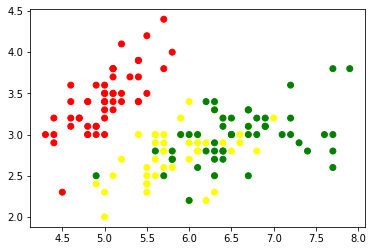

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()
# Two axis 3 classes

In [6]:
print("Data shape",data.shape)
print("Labels shape",labels.shape)

Data shape (150, 2)
Labels shape (150,)


## Multi class classification

In [7]:
# Train and test split
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0,test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)

(120, 2) (30, 2) (150,)


In [8]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(120, 3) (30, 3)


## FF Class

In [9]:
# Most of it remains the same it has some crutial differences
class FFNetwork:
  # We are incring the number of neurons in the hidden layer. Having more neurons means. 
  # It is a more complex network, it is a more expressive network, it requres more amount of training, 
  # but it can possibly learn more xomplex data patterns
  def __init__(self, num_hidden=2, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):
        
    self.params={}
    self.num_layers=2
    self.layer_sizes = [2, num_hidden, 3]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    np.random.seed(0)
    
    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
    
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
    
  def get_accuracy(self):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    return accuracy_train,accuracy_val
    
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 2) -> (N, 2)
    self.H2 = self.softmax(self.A2) # (N, 2)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
  
  # We have to add the L2 regularisation, we have this additional term L2_norm = False
  def fit(self, X, Y, epochs=1, algo= "GD",l2_norm=False, lambda_val=0.8, display_loss=False, eta=1):
    train_accuracies={}
    val_accuracies={}
    if display_loss:
      loss = []
      weight_mag = []
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      self.grad(X, Y)
      for i in range(1,self.num_layers+1):
        # If the l2 norm is not true you go to the else or else we go to if
        if l2_norm:
          # As we are doing L2 regularisation we have this additional term - it is multiplying lamda times the parameter itself
          # it is basically doing the poin wise multiplication of Lamda with the parameters and adding that to the update value  
          # So if we increse the lamda we increse the amount of regularisation we are introducing
          self.params["W"+str(i)] -= (eta * lambda_val)/m * self.params["W"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
        else:
          # we will modify the weights as we used to do before   
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      train_accuracy,val_accuracy=self.get_accuracy()
      train_accuracies[num_epoch]=train_accuracy
      val_accuracies[num_epoch]=val_accuracy
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(log_loss(np.argmax(Y, axis=1), Y_pred))
        weight_mag.append((norm(self.params["W1"]) + norm(self.params["W2"]) + norm(self.params["B1"]) + norm(self.params["B2"]))/18)
    
    # In the end of epochs we are looking at Training accuracies and Validatoin Accuracy    
    plt.plot(train_accuracies.values(),label="Train accuracy")
    plt.plot(val_accuracies.values(),label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))*0.9)
    plt.plot(np.ones((epochs, 1))*0.33)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    if display_loss:
      fig, ax1 = plt.subplots()
      # For 2 different colors
      color = 'tab:red'
      ax1.set_xlabel('epochs')
      ax1.set_ylabel('Log Loss', color=color)
      ax1.plot(loss, '-o', color=color)
      ax1.tick_params(axis='y', labelcolor=color)
      ax2 = ax1.twinx()  
      color = 'tab:blue'
      ax2.set_ylabel('Weight Magnitude', color=color)  # we already handled the x-label with ax1
      ax2.plot(weight_mag, '-*', color=color)
      ax2.tick_params(axis='y', labelcolor=color)
      fig.tight_layout()  
      plt.show()

  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()                               

What will be the additional term of gradient during backpropagation of weight W12 if we use L2 regularization?  
lamda * W12

In [10]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

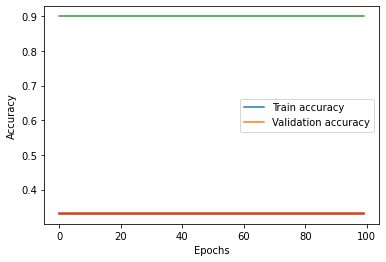

Training accuracy 0.3333
Validation accuracy 0.3333


In [11]:
# num_hidden is the only attribute we are adding all the other we are thaking as default
model = FFNetwork(num_hidden=1)
# If we increase or decrease the learning rate it is not helping that much
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

# Firstly we have to note that it is a plot of accuracy, 
# purple line here denotes 0.33 which is the line we plotted by ourself as a bad baseline, 
# and we aldo plotted a red line which is 0.9 which is a baseline for a good accuracy
# Blue line is showing Train accuracy, green line is the Validation accuracy.
# It is not learning enough this can be die to the  fact that the model does not have enough expressive power in the network.
# The gap between the training accuracy asd the and the red line (which is an indication of good performence) is very high, 
# This shows that there is a large bias(bias is an inaccuracy from what we would typically want to expect in a train and and validatoin case)

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

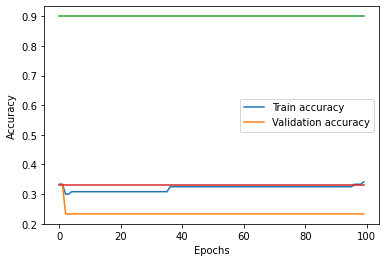

Training accuracy 0.3417
Validation accuracy 0.2333


In [12]:
# Let us increase the number of hidden neurons to 2
model = FFNetwork(num_hidden=2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, display_loss=False)
print_accuracy()
# The model is not complex enough it is incapable of learning patterns in the data that we have 

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/400 [00:00<?, ?epoch/s]

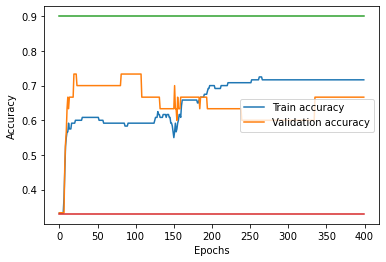

Training accuracy 0.7167
Validation accuracy 0.6667


In [13]:
# Let us increase the number of hidden neurons to 4
model = FFNetwork(num_hidden=4)
# We have used a smaller learning rate here as we have seen that when we use larger learning rates here there is a lot of ossilations
# So as a general thumb of rule as we go towards larger number of hidden neurons we have to use smaller learning rates.
# Oviously as we use a smaller learning rate we have to increase the number of epochs 
model.fit(X_train, y_OH_train, epochs=400, eta=0.25, display_loss=False)
print_accuracy()
# Firstly we are seeing that something is happening and it has crossed the purple line (which was an indicator of bad performance)
# As we can see the bias is reducing (The gap between the red line and the Tranning accuracy).
# Varience is the difference b/w the performence of the Training accuracy and the Validation accuracy
# Varience in general denote how much is accuracyvarying across different samples of the same data.
# Our concer first is to reduce the bias then the varience, we will think about the varience prblem as we get to it.

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/500 [00:00<?, ?epoch/s]

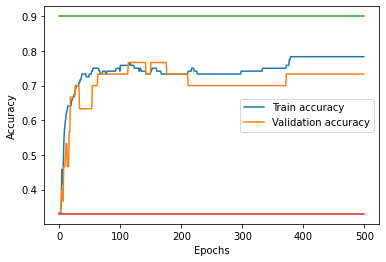

Training accuracy 0.7833
Validation accuracy 0.7333


In [14]:
# As we want to decrease the boas first and to do that,
# we would want a more complex model and we can achieve that by increasing the number of neurons in our model
model = FFNetwork(num_hidden=8)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=False)
print_accuracy()
# Still the varience is still not a problem, the main problem is that the bias is still higher that we would want

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/500 [00:00<?, ?epoch/s]

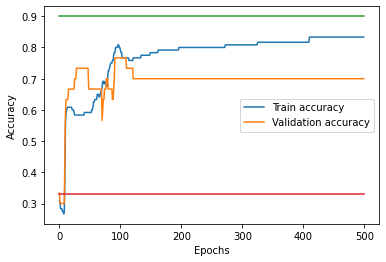

Training accuracy 0.8333
Validation accuracy 0.7


In [15]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=False)
print_accuracy()
# As we can see that the training data keeps increasing its accuracy, so we are continuing to reduce my bias further
# At this point we can be satisfied with our bias and look towards varience as the gap b/w the Training acc. and Validation is now increased.
# Thsi is beacause as the Training data increases the Validation data does not improve.
# At this point he varience starts to dominate out thinking process, but we would like it to push it a bit more.

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

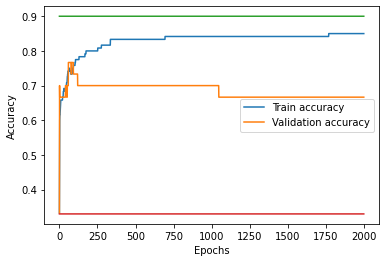

Training accuracy 0.85
Validation accuracy 0.6667


In [16]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
print_accuracy()
# As expected the overfitting continues, we are able to push the accuracy upto 0.85 on the training data as ooposed to 0.83 before
# In the green dataset, it not only makes no improvement after a point but starts to do worse as some point. Clearly we are in the overfit region
# This is the place we have to introduce regularisation and hence L2 norm.

## Add L2 Regularization

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

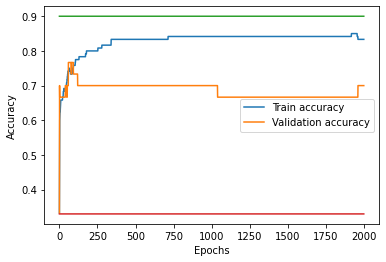

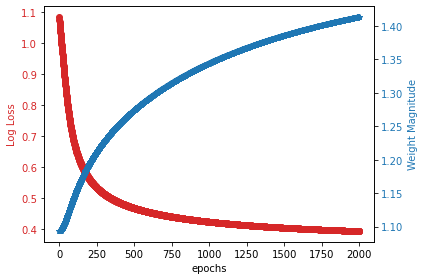

Training accuracy 0.8333
Validation accuracy 0.7


In [17]:
# We are using the same model of 64 neurons, which had overfit data, here we have the L2_norm - True, 
# We are using lamda with a value of 0.1. (It is not to clear what a good lamda term is - we do not know what is a good trade off)
# The thing we know for sure is if we increase lamda, we are adding more regularisatoin, if we have a small lamda we are adding poor regularisation
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=0.1, display_loss=True)
print_accuracy()
# We have introduced a second plot which is a twin plot, 
# where in the primary Y axis we have the - Log Loss on the secondry Y axis we have the Weight Magnitude which is th aquare of the weights

# Due to the L2 Regularisation we can see that the Validation Accuracy is incresing towards the end but not still enough for us to reduce the varience.
# Hence we would like to increse the value of lamda
# Also the  weighted Magnitude continues to increase, we can nad should use lamda to put a cap on that.

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

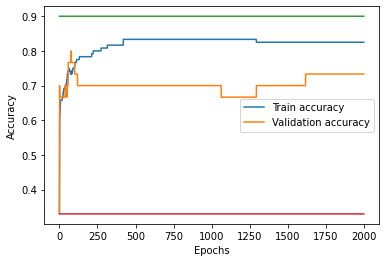

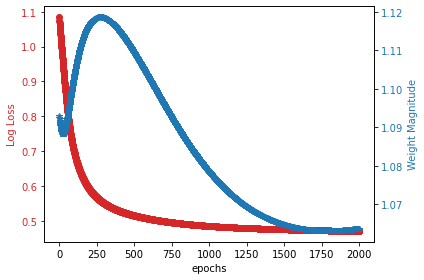

Training accuracy 0.825
Validation accuracy 0.7333


In [18]:
# Increasing the value of Lamda
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=1, display_loss=True)
print_accuracy()
# It is important to realise that as we add Regularisation the Training Accuracy is going to suffer a bit. 
# So the bias wrt to the trainig dataset has incresed, but importantly the Validation data is increasing quite a bit.
# As we can see in the twin plot that the Weight magnitude capped, it capps when Weight magnitude is too large and Log loss is too small.


<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

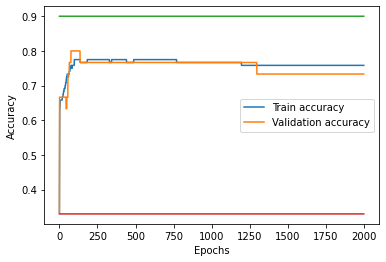

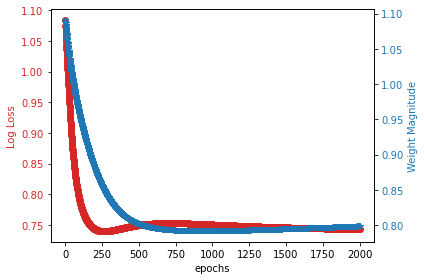

Training accuracy 0.7583
Validation accuracy 0.7333


In [19]:
# Further incresing the Lamda value
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=5, display_loss=True)
print_accuracy()
# The first thing we can see that the 1st plot the Training and Validatin accuracy are quite intertwined to each other. This tells that the varience is small.
# As we can see here the varience has increased but the bias has increased  
# We can see from the twin plot that, at some point the log loss comes too low, nad hence it actually increases.
# But it appears to be a fair compramise we are making to get to a decent varience

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

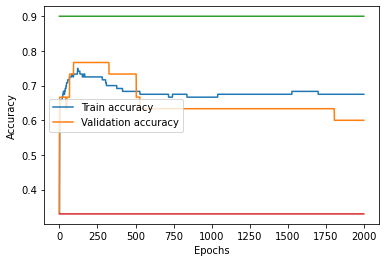

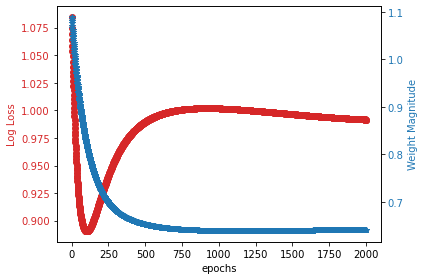

Training accuracy 0.675
Validation accuracy 0.6


In [20]:
# If we increase the lamda further as we can see we are over regularising
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=10, display_loss=True)
print_accuracy()
# There is still some varience, but overall we are in the low varience zone and in a high bias zone
# Larger values of lambda parameter of regularization leads to underfitting the data.

## Add noise to training data set

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

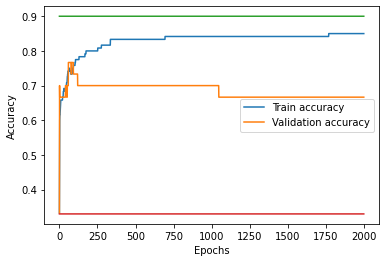

Training accuracy 0.85
Validation accuracy 0.6667


In [21]:
# We are trying to change the feature values without affecting the class, 
# but when working with regression data one may also add noise to the output, but in this caase we will be only adding Noise to the input data
# This is the model we have been working on - Overfitting
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
print_accuracy()

0.01


<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

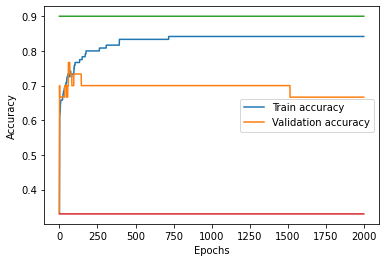

Training accuracy 0.8417
Validation accuracy 0.6667
0.05


<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

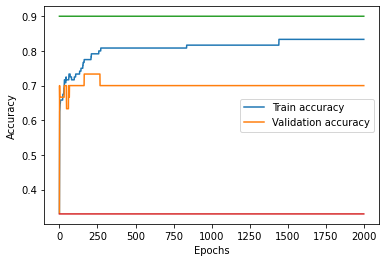

Training accuracy 0.8333
Validation accuracy 0.7
0.1


<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

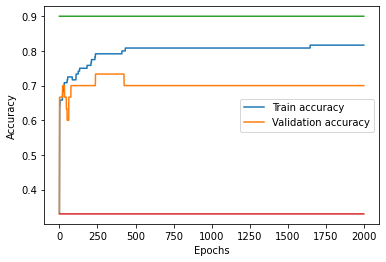

Training accuracy 0.8167
Validation accuracy 0.7
0.15


<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

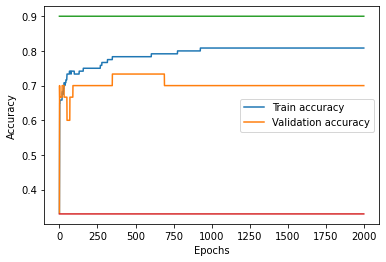

Training accuracy 0.8083
Validation accuracy 0.7
0.18


<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

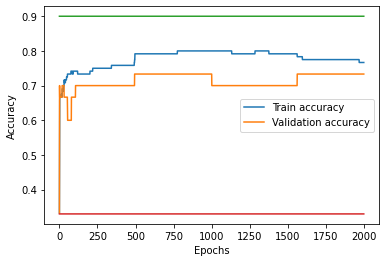

Training accuracy 0.7667
Validation accuracy 0.7333
0.2


<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/2000 [00:00<?, ?epoch/s]

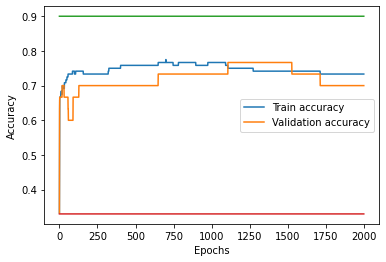

Training accuracy 0.7333
Validation accuracy 0.7


In [22]:
# We are lopoing over different noise fractions - we are making a noisy version of X train.
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
  print(noise_fraction)
  # np.random.randn(X_train.shape[0], X_train.shape[1]) generates vectors of the size (shape) which are b/w 0 and 1
  # Net waht we are doing is we are adding a multiplicative noise of the fractional value
  X_train_noisy = X_train * (1 - noise_fraction*np.random.randn(X_train.shape[0], X_train.shape[1]))
  model = FFNetwork(num_hidden=64)
  # We are fitting the model to the noisy data we created 
  model.fit(X_train_noisy, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
  print_accuracy()

# We are able to see that as the noise fraction increas the Training accuracy decreases a bit and the Validation accuracy increases.
# At 18% we were able to see the changes (trade off) - 
# As we take 20% we are able to seet that we overdid it a bit and the traning and validation both are decreasing. It is still not a bad solution

## Early stopping

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/500 [00:00<?, ?epoch/s]

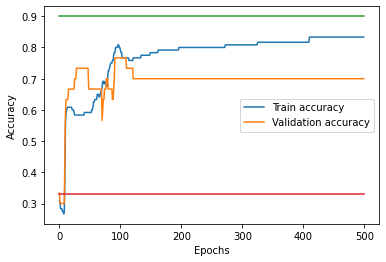

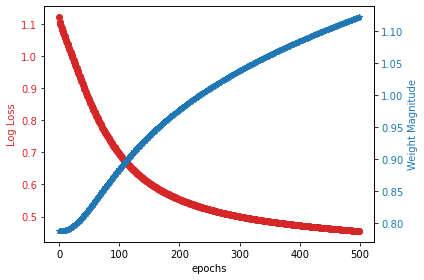

Training accuracy 0.8333
Validation accuracy 0.7


In [23]:
# Taking an example of before , it was also clear case of overfititng
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=True)
print_accuracy()

<ipython-input-9-c448f4e5e2f0>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

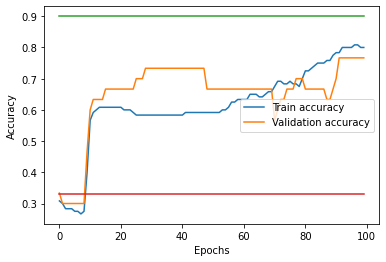

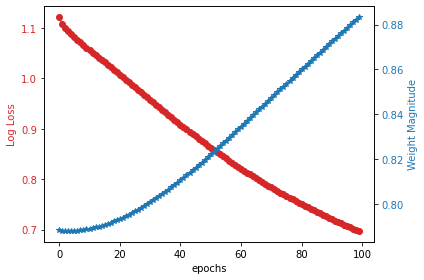

Training accuracy 0.8
Validation accuracy 0.7667


In [24]:
# Insted of running it for all tehe 500 epochs we are running this for only 100 epochs
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=100, eta=0.2, display_loss=True)
print_accuracy()
# We are able to see that the varience is fairly small at this point.
# The bias is also good
# This is the best trade off we have got so far, we had not added Noise neither did we add any L2 reguliser, 
# just by stoppin the training at the appropritae time, we are able to get thse good results, 
# wherein the Loss has reducuded signinficantly but, the weights have not become too large hence the model is not that complex

As we can see that we are not saturating nay of the parameters in the twin plot. We are doing less computation and able to avoid overfititng.
It is a good practice to have checkpoints, so that at the end of every epoch or every 10th epoch  take a checkpoint, which will store all the weight and biases for that model at that time. So at the end we can see the plot and say taht instead of haveing the model I have now lets go back to this particular checkpoint and see if the bias varience trade off is better

## Exercises

* Repeat the above with at least one other activation function / initialisation method pair
* For the iris data-set, repeat the above with the entire data-set, i.e. not with just two inputs - modify the class to support that
* Repeat the above with at least one other data-set (eg. from sklearn.datasets) 